# Classification

- Target = 0 if suicide rate <= national median
- Target = 1 if suicide rate > national median
- Features  = disease rates + state

Import libraries

In [1]:
import pandas as pd
import numpy as np

# DataPrep
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
# Tuning
from skopt import gp_minimize
# Feature Selection
from sklearn.feature_selection import RFE,SelectFromModel
# Models
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Evaluation
from sklearn import metrics

import time
import glob
import shap
root = "../../"

# DataPrep
*You can skip this and load the csv directly after this section*

In [2]:
dict_uf_cod = {11: 'RO',
12: 'AC',
13: 'AM',
14: 'RR',
15: 'PA',
16: 'AP',
17: 'TO',
21: 'MA',
22: 'PI',
23: 'CE',
24: 'RN',
25: 'PB',
26: 'PE',
27: 'AL',
28: 'SE',
29: 'BA',
31: 'MG',
32: 'ES',
33: 'RJ',
35: 'SP',
41: 'PR',
42: 'SC',
43: 'RS',
50: 'MS',
51: 'MT',
52: 'GO',
53: 'DF'}

In [3]:
disease = ""
path = root + "CSV/TabNet/Internacoes_Rate/"
all_files = glob.glob(path + "*.csv")
suicide = pd.read_csv(root +'CSV/Suicide/suicide_rates_08_18.csv', index_col=0)

years = [str(x).zfill(2) for x in range(8,19)]
columns = ["RATE_" + year for year in years]
columns.append("MUNCOD")

disease_list = []

for file in all_files:
    file_name = file.split("\\")[-1]
    disease = file_name.split(".csv")[0]
    disease_df = pd.read_csv(file, sep=',', index_col=0)
    if(set(disease_df.columns) == set(columns)):
        disease_list.append(disease)
print(len(disease_list), " diseases")

313  diseases


In [4]:
initial_df = pd.DataFrame()
percentage_valid_values = 0.8
for i in range(0,len(years)-1):
    col_year_suicide = "RATE_" + years[i+1]
    year_df = suicide[[col_year_suicide, "MUNCOD"]].copy()
    
    for disease in disease_list:
        col_year_disease = "RATE_" + years[i]
        disease_df = pd.read_csv(path + disease + ".csv", sep=',', index_col=0)
        disease_df = disease_df[[col_year_disease, "MUNCOD"]]
        disease_df[disease] = disease_df[col_year_disease] 
        disease_df = disease_df.drop(columns={col_year_disease})
        year_df = pd.merge(disease_df, year_df, left_on="MUNCOD", right_on="MUNCOD", how='right')
    N = int(year_df.shape[1]*percentage_valid_values)
    year_df = year_df.dropna(thresh=N) # a column needs at least N non-NaNs to survive
    year_df["TARGET"] = (year_df[col_year_suicide] > year_df[col_year_suicide].median()).astype(int)
    year_df = year_df.drop(columns=col_year_suicide)
    initial_df = pd.concat([initial_df, year_df])

initial_df.head()

,MUNCOD,ÚLCERA_GÁSTRICA_E_DUODENAL,VEIAS_VARICOSAS_DAS_EXTREMIDADES_INFERIORES,VARICELA_E_HERPES_ZOSTER,UROLITÍASE,TÉTANO_NEONATAL,TUBERC_INTEST_PERITÔNIO_GLÂNGL_MESENTÉRICOS,TUBERCULOSE_ÓSSEA_E_DAS_ARTICULAÇÕES,TUBERCULOSE_PULMONAR,TUBERCULOSE_MILIAR,...,ANEMIA_POR_DEFICIÊNCIA_DE_FERRO,ANCILOSTOMÍASE,AMEBÍASE,ALGUNS_TRANSTORNOS_ENVOLVENDO_MECANISMO_IMUNITÁRIO,AFECÇ_HEMORRÁG_E_OUTR_DOENÇ_SANG_E_ÓRG_HEMATOPOÉT,ACID_VASCULAR_CEREBR_NÃO_ESPEC_HEMORRÁG_OU_ISQUÊM,ACID_VASCULAR_CEREBR_ISQUÊM_TRANSIT_E_SÍNDR_CORREL,ABORTO_POR_RAZÕES_MÉDICAS,ABORTO_ESPONTÂNEO,TARGET
0,110001,28.481914,40.688449,0.0,142.409570,NaN,NaN,NaN,0.0,NaN,...,0.000000,NaN,0.000000,NaN,44.757293,40.688449,32.550759,NaN,126.134191,1
1,110002,9.458389,54.385737,0.0,15.369882,NaN,0.0,NaN,0.0,0.0,...,0.000000,NaN,0.000000,0.0,1.182299,39.015855,0.000000,0.0,1.182299,0
3,110004,5.110972,21.721631,0.0,63.887150,NaN,NaN,NaN,0.0,0.0,...,2.555486,NaN,NaN,0.0,3.833229,106.052669,3.833229,0.0,2.555486,1
8,110009,0.000000,48.921969,0.0,24.460985,NaN,NaN,NaN,0.0,NaN,...,0.000000,NaN,0.000000,NaN,3.494426,0.000000,17.472132,0.0,0.000000,1
9,110010,2.466639,9.866555,0.0,12.333194,NaN,0.0,0.0,0.0,0.0,...,41.932858,0.0,2.466639,NaN,2.466639,36.999581,0.000000,0.0,197.331097,1


In [5]:
df = initial_df.copy()

In [6]:
# Fill NaN values with 0
df = df.fillna(0)

# Get MUNCOD from UF
df['UF'] = df['MUNCOD'] / 10000
df['UF'] = df['UF'].astype(int)
df['UF'].replace(dict_uf_cod, inplace=True)
dummy = pd.get_dummies(df['UF'])
df = pd.concat([df, dummy], axis=1)
df = df.drop(['MUNCOD', 'UF'], axis=1)
df.head()

,ÚLCERA_GÁSTRICA_E_DUODENAL,VEIAS_VARICOSAS_DAS_EXTREMIDADES_INFERIORES,VARICELA_E_HERPES_ZOSTER,UROLITÍASE,TÉTANO_NEONATAL,TUBERC_INTEST_PERITÔNIO_GLÂNGL_MESENTÉRICOS,TUBERCULOSE_ÓSSEA_E_DAS_ARTICULAÇÕES,TUBERCULOSE_PULMONAR,TUBERCULOSE_MILIAR,TUBERCULOSE_DO_SISTEMA_NERVOSO,...,PR,RJ,RN,RO,RR,RS,SC,SE,SP,TO
0,28.481914,40.688449,0.0,142.409570,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
1,9.458389,54.385737,0.0,15.369882,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
3,5.110972,21.721631,0.0,63.887150,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
8,0.000000,48.921969,0.0,24.460985,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
9,2.466639,9.866555,0.0,12.333194,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0


In [7]:
df.to_csv("df_classification_highest_rates.csv")

# Model

In [2]:
df = pd.read_csv("df_classification_highest_rates.csv",index_col=0)

Checking the number of 0s and 1s in TARGET column

In [3]:
unique, counts = np.unique(df["TARGET"].values, return_counts=True)
dict(zip(unique, counts))

{0: 4680, 1: 4670}

Define X and y

In [4]:
X = df.drop(columns=["TARGET"])
y = df["TARGET"]

X.shape

(9350, 340)

Get scaled version of X

In [5]:
mm = MinMaxScaler()
sc = StandardScaler()
X_mm = mm.fit_transform(X)
X_sc = sc.fit_transform(X)

Define some functions

In [6]:
def get_average_feat_importance(feature_importance_list):
    final_feat_df = pd.DataFrame()
    for i, feat_df in enumerate(feature_importance_list):
        feat_df = feat_df.rename(columns={"Importance": i})
        if final_feat_dfdf.empty:
            final_feat_df = feat_df
        else:
            final_feat_df = pd.merge(final_feat_df, feat_df, on="Feature", how="right")
    final_feat_df = final_feat_df.fillna(0)
    final_feat_df["Avg_importance"] = final_feat_df.sum(axis=1)/(final_feat_df.shape[1] -1)
    final_feat_df = final_feat_df[["Feature", "Avg_importance"]]
    return final_feat_df.sort_values(by="Avg_importance", ascending=False)

In [7]:
def sfm_feature_selector(X_train,y_train,max_features):
    embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100),max_features=max_features)
    embeded_rf_selector.fit(X_train, y_train)

    embeded_rf_support = embeded_rf_selector.get_support()
    embeded_rf_feature = X_train.loc[:,embeded_rf_support].columns.tolist()
    print(str(len(embeded_rf_feature)), 'selected features (SFM)')
    return embeded_rf_feature

In [8]:
def get_average(scores_list):
    scores_avg_test = []
    for i in range(len(scores_list[0])):
        arr_list = [x[i] for x in scores_list]
        avg_result = np.array(arr_list).mean(axis=0)
        scores_avg_test.append(avg_result)
    return scores_avg_test

## 1. Naive Bayes

In [24]:
from mixed_naive_bayes import MixedNB

start = time.time()
num_feat = 30
kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
scores = pd.DataFrame({"accuracy_train": [], "accuracy_test": [], "scores_train": [], "scores_test": []})
feature_importance_list = []
count = 1
for train_index, test_index in kf.split(X,y):
    print("=============== RUN {} ===============".format(count))
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    classifier = MixedNB(categorical_features=[X.columns.get_loc(col) for col in list(dict_uf_cod.values())])
    classifier.fit(X,y)
    classifier.predict(X)
    
    print("# Making predictions")
    y_pred = classifier.predict(X_test) 
    y_pred_train = classifier.predict(X_train)
    
    print("# Calculating metrics")
    print("Train")
    print(metrics.confusion_matrix(y_train, y_pred_train))
    print(metrics.classification_report(y_train, y_pred_train, digits=3))
    print("Test")
    print(metrics.confusion_matrix(y_test, y_pred))
    print(metrics.classification_report(y_test, y_pred, digits=3))
    scores = scores.append({"accuracy_train": metrics.accuracy_score(y_train,y_pred_train),
                  "accuracy_test": metrics.accuracy_score(y_test,y_pred),
                  "scores_train": metrics.precision_recall_fscore_support(y_train,y_pred_train),
                  "scores_test": metrics.precision_recall_fscore_support(y_test,y_pred)}, ignore_index=True)
  
    print("\n")
    count += 1
print("=============== SUMMARY ===============")

print("# Average Metrics")
print("## Train")
avg_accuracy_train = scores["accuracy_train"].mean()
avg_score_train = get_average(scores["scores_train"])
print("accuracy_train:", avg_accuracy_train)
print("precision_train:", avg_score_train[0].mean())
print("recall_train:", avg_score_train[1].mean())
print("f1_score_train:", avg_score_train[2].mean())
print("## Test")
avg_accuracy_test = scores["accuracy_test"].mean()
avg_score_test = get_average(scores["scores_test"])
print("accuracy_test:", avg_accuracy_test)
print("precision_test:", avg_score_test[0].mean())
print("recall_test:", avg_score_test[1].mean())
print("f1_score_test:", avg_score_test[2].mean())

end = time.time()

print("\nTotal run time:", end-start)

=============== RUN 1 ===============
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
# Making predictions
# Calculating metrics
Train
[[3744    0]
 [3736    0]]
              precision    recall  f1-score   support

           0      0.501     1.000     0.667      3744
           1      0.000     0.000     0.000      3736

    accuracy                          0.501      7480
   macro avg      0.250     0.500     0.334      7480
weighted avg      0.251     0.501     0.334      7480

Test
[[936   0]
 [934   0]]
              precision    recall  f1-score   support

           0      0.501     1.000     0.667       936
           1      0.000     0.000     0.000       934

    accuracy                          0.501      1870
   macro avg      0.250     0.500     0.334      1870
weighted avg      0.251     0.501     0.334      1870



=============== RUN 2 ===============
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


# Making predictions
# Calculating metrics
Train
[[3744    0]
 [3736    0]]
              precision    recall  f1-score   support

           0      0.501     1.000     0.667      3744
           1      0.000     0.000     0.000      3736

    accuracy                          0.501      7480
   macro avg      0.250     0.500     0.334      7480
weighted avg      0.251     0.501     0.334      7480

Test
[[936   0]
 [934   0]]
              precision    recall  f1-score   support

           0      0.501     1.000     0.667       936
           1      0.000     0.000     0.000       934

    accuracy                          0.501      1870
   macro avg      0.250     0.500     0.334      1870
weighted avg      0.251     0.501     0.334      1870



=============== RUN 3 ===============
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
# Making predictions
# Calculating metrics
Train
[[3744    0]
 [3736    0]]
              precision    recall  f1-score   support

           0   

## 2. LogisticRegression Model

### 2.1 Using MinMax Scaling

In [38]:
start = time.time()
num_feat = 30
kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
scores = pd.DataFrame({"accuracy_train": [], "accuracy_test": [], "scores_train": [], "scores_test": []})
feature_importance_list = []
count = 1
for train_index, test_index in kf.split(X_mm,y):
    print("=============== RUN {} ===============".format(count))
    X_train, X_test = X_mm[train_index], X_mm[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    print("# Fitting the model")
    classifier = LogisticRegression()
    classifier.fit(X_train, y_train)
    
    print("# Making predictions")
    y_pred = classifier.predict(X_test) 
    y_pred_train = classifier.predict(X_train)
    
    print("# Calculating metrics")
    print("Train")
    print(metrics.confusion_matrix(y_train, y_pred_train))
    print(metrics.classification_report(y_train, y_pred_train, digits=3))
    print("Test")
    print(metrics.confusion_matrix(y_test, y_pred))
    print(metrics.classification_report(y_test, y_pred, digits=3))
    scores = scores.append({"accuracy_train": metrics.accuracy_score(y_train,y_pred_train),
                  "accuracy_test": metrics.accuracy_score(y_test,y_pred),
                  "scores_train": metrics.precision_recall_fscore_support(y_train,y_pred_train),
                  "scores_test": metrics.precision_recall_fscore_support(y_test,y_pred)}, ignore_index=True)
  
    print("\n")
    count += 1
print("=============== SUMMARY ===============")

print("# Average Metrics")
print("## Train")
avg_accuracy_train = scores["accuracy_train"].mean()
avg_score_train = get_average(scores["scores_train"])
print("accuracy_train:", avg_accuracy_train)
print("precision_train:", avg_score_train[0].mean())
print("recall_train:", avg_score_train[1].mean())
print("f1_score_train:", avg_score_train[2].mean())
print("## Test")
avg_accuracy_test = scores["accuracy_test"].mean()
avg_score_test = get_average(scores["scores_test"])
print("accuracy_test:", avg_accuracy_test)
print("precision_test:", avg_score_test[0].mean())
print("recall_test:", avg_score_test[1].mean())
print("f1_score_test:", avg_score_test[2].mean())

end = time.time()

print("\nTotal run time:", end-start)

=============== RUN 1 ===============
# Fitting the model
# Making predictions
# Calculating metrics
Train
[[2669 1075]
 [1116 2620]]
              precision    recall  f1-score   support

           0      0.705     0.713     0.709      3744
           1      0.709     0.701     0.705      3736

    accuracy                          0.707      7480
   macro avg      0.707     0.707     0.707      7480
weighted avg      0.707     0.707     0.707      7480

Test
[[653 283]
 [314 620]]
              precision    recall  f1-score   support

           0      0.675     0.698     0.686       936
           1      0.687     0.664     0.675       934

    accuracy                          0.681      1870
   macro avg      0.681     0.681     0.681      1870
weighted avg      0.681     0.681     0.681      1870



=============== RUN 2 ===============
# Fitting the model
# Making predictions
# Calculating metrics
Train
[[2670 1074]
 [1142 2594]]
              precision    recall  f1-score   su

### 2.2 Using StandardScaler

In [39]:
start = time.time()
num_feat = 30
kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
scores = pd.DataFrame({"accuracy_train": [], "accuracy_test": [], "scores_train": [], "scores_test": []})
feature_importance_list = []
count = 1
for train_index, test_index in kf.split(X_sc,y):
    print("=============== RUN {} ===============".format(count))
    X_train, X_test = X_sc[train_index], X_sc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    print("# Fitting the model")
    classifier = LogisticRegression()
    classifier.fit(X_train, y_train)
    
    print("# Making predictions")
    y_pred = classifier.predict(X_test) 
    y_pred_train = classifier.predict(X_train)
    
    print("# Calculating metrics")
    print("Train")
    print(metrics.confusion_matrix(y_train, y_pred_train))
    print(metrics.classification_report(y_train, y_pred_train, digits=3))
    print("Test")
    print(metrics.confusion_matrix(y_test, y_pred))
    print(metrics.classification_report(y_test, y_pred, digits=3))
    scores = scores.append({"accuracy_train": metrics.accuracy_score(y_train,y_pred_train),
                  "accuracy_test": metrics.accuracy_score(y_test,y_pred),
                  "scores_train": metrics.precision_recall_fscore_support(y_train,y_pred_train),
                  "scores_test": metrics.precision_recall_fscore_support(y_test,y_pred)}, ignore_index=True)
  
    print("\n")
    count += 1
print("=============== SUMMARY ===============")

print("# Average Metrics")
print("## Train")
avg_accuracy_train = scores["accuracy_train"].mean()
avg_score_train = get_average(scores["scores_train"])
print("accuracy_train:", avg_accuracy_train)
print("precision_train:", avg_score_train[0].mean())
print("recall_train:", avg_score_train[1].mean())
print("f1_score_train:", avg_score_train[2].mean())
print("## Test")
avg_accuracy_test = scores["accuracy_test"].mean()
avg_score_test = get_average(scores["scores_test"])
print("accuracy_test:", avg_accuracy_test)
print("precision_test:", avg_score_test[0].mean())
print("recall_test:", avg_score_test[1].mean())
print("f1_score_test:", avg_score_test[2].mean())

end = time.time()

print("\nTotal run time:", end-start)

=============== RUN 1 ===============
# Fitting the model
# Making predictions
# Calculating metrics
Train
[[2691 1053]
 [1091 2645]]
              precision    recall  f1-score   support

           0      0.712     0.719     0.715      3744
           1      0.715     0.708     0.712      3736

    accuracy                          0.713      7480
   macro avg      0.713     0.713     0.713      7480
weighted avg      0.713     0.713     0.713      7480

Test
[[645 291]
 [317 617]]
              precision    recall  f1-score   support

           0      0.670     0.689     0.680       936
           1      0.680     0.661     0.670       934

    accuracy                          0.675      1870
   macro avg      0.675     0.675     0.675      1870
weighted avg      0.675     0.675     0.675      1870



=============== RUN 2 ===============
# Fitting the model
# Making predictions
# Calculating metrics
Train
[[2687 1057]
 [1124 2612]]
              precision    recall  f1-score   su

# Feature Selection: SFM
30 selected features (SFM)
# Fitting the model
# Making predictions
# Calculating metrics
Train
[[2299  977]
 [1294 1975]]
              precision    recall  f1-score   support

           0      0.640     0.702     0.669      3276
           1      0.669     0.604     0.635      3269

    accuracy                          0.653      6545
   macro avg      0.654     0.653     0.652      6545
weighted avg      0.654     0.653     0.652      6545

Test
[[988 416]
 [584 817]]
              precision    recall  f1-score   support

           0      0.628     0.704     0.664      1404
           1      0.663     0.583     0.620      1401

    accuracy                          0.643      2805
   macro avg      0.646     0.643     0.642      2805
weighted avg      0.646     0.643     0.642      2805

# SHAP analysis


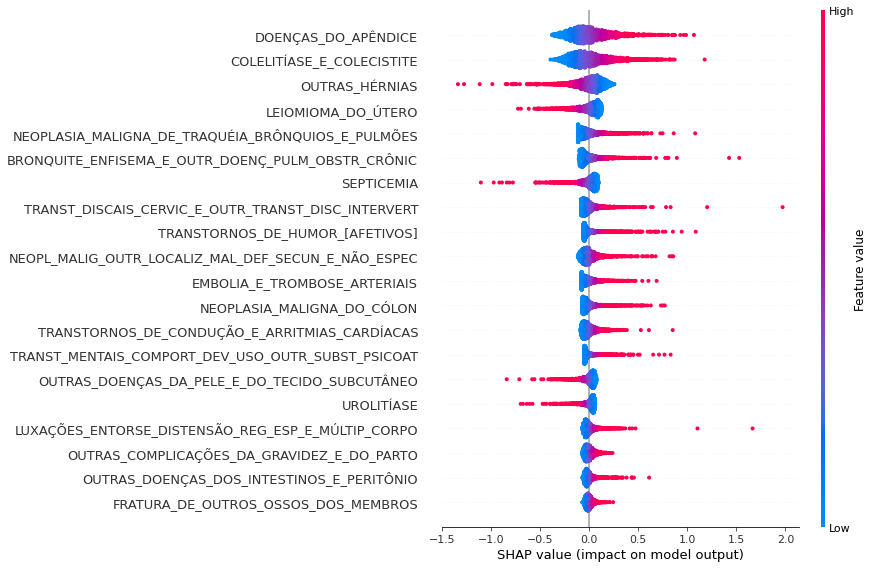

In [18]:
X_train, X_test, y_train, y_test = train_test_split(pd.DataFrame(X_mm, index=X.index, columns=X.columns),y,random_state=42, test_size=0.3, stratify=y)
num_feat = 30
    
print("# Feature Selection: SFM")
selected_sfm_features = sfm_feature_selector(X_train,y_train,num_feat)
X_train = X_train[selected_sfm_features]
X_test = X_test[selected_sfm_features]

print("# Fitting the model")
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

print("# Making predictions")
y_pred = classifier.predict(X_test) 
y_pred_train = classifier.predict(X_train)

print("# Calculating metrics")
print("Train")
print(metrics.confusion_matrix(y_train, y_pred_train))
print(metrics.classification_report(y_train, y_pred_train, digits=3))
print("Test")
print(metrics.confusion_matrix(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred, digits=3))

print("# SHAP analysis")
explainer = shap.LinearExplainer(classifier, X_train, feature_perturbation="interventional")
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)

## 3. Random Forest Model

In [26]:
start = time.time()
num_feat = 30
kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
scores = pd.DataFrame({"accuracy_train": [], "accuracy_test": [], "scores_train": [], "scores_test": []})
feature_importance_list = []
count = 1
for train_index, test_index in kf.split(X,y):
    print("=============== RUN {} ===============".format(count))
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    print("# Feature Selection: SFM")
    selected_sfm_features = sfm_feature_selector(X_train,y_train,num_feat)
    X_train = X_train[selected_sfm_features]
    X_test = X_test[selected_sfm_features]
    
    print("# Bayesian Optimization")
    def train_model(params):
        n_estimators = params[0]
        max_depth = params[1]
        min_samples_leaf = params[2]
        max_features = params[3]

        xf_train_params,xf_val,yf_train_params,yf_val = train_test_split(X_train,y_train,test_size=0.33,random_state=42)

        model = RandomForestClassifier(n_jobs=-1, random_state=42,n_estimators=n_estimators, 
                                      max_depth=max_depth,min_samples_leaf=min_samples_leaf,max_features=max_features)

        model.fit(xf_train_params,yf_train_params)
        yf_pred = model.predict(xf_val)

        return metrics.accuracy_score(yf_val, yf_pred)
    space = [
        (5,1000), #n_estimators
        (3,30), #max_depth
        (2,200), #min_samples_leaf
        (0.25,1.00) #max_features
    ]
    resultado_gp = gp_minimize(train_model, space, random_state=42, verbose=0, n_calls=30, n_random_starts=10)
    
    n_estimators = resultado_gp.x[0]
    max_depth = resultado_gp.x[1]
    min_samples_leaf = resultado_gp.x[2]
    max_features = resultado_gp.x[3]
    
    print("# Fitting the model")
    classifier = RandomForestClassifier(random_state=42,n_estimators=n_estimators, 
                                      max_depth=max_depth,min_samples_leaf=min_samples_leaf,max_features=max_features)
    classifier.fit(X_train,y_train)
    
    print("# Making predictions")
    y_pred = classifier.predict(X_test) 
    y_pred_train = classifier.predict(X_train)
    
    print("# Calculating metrics")
    print("Train")
    print(metrics.confusion_matrix(y_train, y_pred_train))
    print(metrics.classification_report(y_train, y_pred_train, digits=3))
    print("Test")
    print(metrics.confusion_matrix(y_test, y_pred))
    print(metrics.classification_report(y_test, y_pred, digits=3))
    scores = scores.append({"accuracy_train": metrics.accuracy_score(y_train,y_pred_train),
                  "accuracy_test": metrics.accuracy_score(y_test,y_pred),
                  "scores_train": metrics.precision_recall_fscore_support(y_train,y_pred_train),
                  "scores_test": metrics.precision_recall_fscore_support(y_test,y_pred)}, ignore_index=True)
    
    print("# Get Feature Importance")
    importance = classifier.feature_importances_
    feature_importance_list.append(pd.DataFrame({"Feature": X_train.columns, "Importance": importance}).sort_values(by="Importance", ascending=False))
    
    print("\n")
    count += 1
print("=============== SUMMARY ===============")
print("# Average Feature Importance")
final_feat_df = get_average_feat_importance(feature_importance_list)
print(final_feat_df.head(20))

print("# Average Metrics")
print("## Train")
avg_accuracy_train = scores["accuracy_train"].mean()
avg_score_train = get_average(scores["scores_train"])
print("accuracy_train:", avg_accuracy_train)
print("precision_train:", avg_score_train[0].mean())
print("recall_train:", avg_score_train[1].mean())
print("f1_score_train:", avg_score_train[2].mean())
print("## Test")
avg_accuracy_test = scores["accuracy_test"].mean()
avg_score_test = get_average(scores["scores_test"])
print("accuracy_test:", avg_accuracy_test)
print("precision_test:", avg_score_test[0].mean())
print("recall_test:", avg_score_test[1].mean())
print("f1_score_test:", avg_score_test[2].mean())

end = time.time()

print("\nTotal run time:", end-start)

=============== RUN 1 ===============
# Feature Selection: SFM
30 selected features (SFM)
# Bayesian Optimization


C:\Users\pypas\anaconda3\envs\ML\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


# Fitting the model
# Making predictions
# Calculating metrics
Train
[[2463 1281]
 [1250 2486]]
              precision    recall  f1-score   support

           0      0.663     0.658     0.661      3744
           1      0.660     0.665     0.663      3736

    accuracy                          0.662      7480
   macro avg      0.662     0.662     0.662      7480
weighted avg      0.662     0.662     0.662      7480

Test
[[611 325]
 [355 579]]
              precision    recall  f1-score   support

           0      0.633     0.653     0.642       936
           1      0.640     0.620     0.630       934

    accuracy                          0.636      1870
   macro avg      0.636     0.636     0.636      1870
weighted avg      0.636     0.636     0.636      1870

# Get Feature Importance


=============== RUN 2 ===============
# Feature Selection: SFM
30 selected features (SFM)
# Bayesian Optimization
# Fitting the model
# Making predictions
# Calculating metrics
Train
[[2466 1278]

C:\Users\pypas\anaconda3\envs\ML\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


# Fitting the model
# Making predictions
# Calculating metrics
Train
[[2492 1252]
 [1391 2345]]
              precision    recall  f1-score   support

           0      0.642     0.666     0.653      3744
           1      0.652     0.628     0.640      3736

    accuracy                          0.647      7480
   macro avg      0.647     0.647     0.647      7480
weighted avg      0.647     0.647     0.647      7480

Test
[[642 294]
 [353 581]]
              precision    recall  f1-score   support

           0      0.645     0.686     0.665       936
           1      0.664     0.622     0.642       934

    accuracy                          0.654      1870
   macro avg      0.655     0.654     0.654      1870
weighted avg      0.655     0.654     0.654      1870

# Get Feature Importance


=============== RUN 4 ===============
# Feature Selection: SFM
30 selected features (SFM)
# Bayesian Optimization
# Fitting the model
# Making predictions
# Calculating metrics
Train
[[2558 1186]

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42, test_size=0.3, stratify=y)
num_feat = 30
    
print("# Feature Selection: SFM")
selected_sfm_features = sfm_feature_selector(X_train,y_train,num_feat)
X_train = X_train[selected_sfm_features]
X_test = X_test[selected_sfm_features]
    
print("# Bayesian Optimization")
def train_model(params):
    n_estimators = params[0]
    max_depth = params[1]
    min_samples_leaf = params[2]
    max_features = params[3]

    xf_train_params,xf_val,yf_train_params,yf_val = train_test_split(X_train,y_train,test_size=0.33,random_state=42)

    model = RandomForestClassifier(n_jobs=-1, random_state=42,n_estimators=n_estimators, 
                                  max_depth=max_depth,min_samples_leaf=min_samples_leaf,max_features=max_features)

    model.fit(xf_train_params,yf_train_params)
    yf_pred = model.predict(xf_val)

    return metrics.accuracy_score(yf_val, yf_pred)
space = [
    (5,1000), #n_estimators
    (3,30), #max_depth
    (2,200), #min_samples_leaf
    (0.25,1.00) #max_features
]
resultado_gp = gp_minimize(train_model, space, random_state=42, verbose=0, n_calls=30, n_random_starts=10)

n_estimators = resultado_gp.x[0]
max_depth = resultado_gp.x[1]
min_samples_leaf = resultado_gp.x[2]
max_features = resultado_gp.x[3]

print("# Fitting the model")
classifier = RandomForestClassifier(random_state=42,n_estimators=n_estimators, 
                                  max_depth=max_depth,min_samples_leaf=min_samples_leaf,max_features=max_features)
classifier.fit(X_train,y_train)

print("# Making predictions")
y_pred = classifier.predict(X_test) 
y_pred_train = classifier.predict(X_train)

print("# Calculating metrics")
print("Train")
print(metrics.confusion_matrix(y_train, y_pred_train))
print(metrics.classification_report(y_train, y_pred_train, digits=3))
print("Test")
print(metrics.confusion_matrix(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred, digits=3))

print("# Get Feature Importance")
importance = classifier.feature_importances_
print(pd.DataFrame({"Feature": X_train.columns, "Importance": importance}))

# Feature Selection: SFM
30 selected features (SFM)
# Bayesian Optimization


The objective has been evaluated at this point before.


# Fitting the model
# Making predictions
# Calculating metrics
Train
[[2140 1136]
 [1138 2131]]
              precision    recall  f1-score   support

           0      0.653     0.653     0.653      3276
           1      0.652     0.652     0.652      3269

    accuracy                          0.653      6545
   macro avg      0.653     0.653     0.653      6545
weighted avg      0.653     0.653     0.653      6545

Test
[[902 502]
 [537 864]]
              precision    recall  f1-score   support

           0      0.627     0.642     0.635      1404
           1      0.633     0.617     0.625      1401

    accuracy                          0.630      2805
   macro avg      0.630     0.630     0.630      2805
weighted avg      0.630     0.630     0.630      2805

# Get Feature Importance
                                              Feature  Importance
0                                          UROLITÍASE    0.013468
1   TRANST_MENTAIS_E_COMPORTAMENTAIS_DEV_USO_DE_ÁL...    0.005120

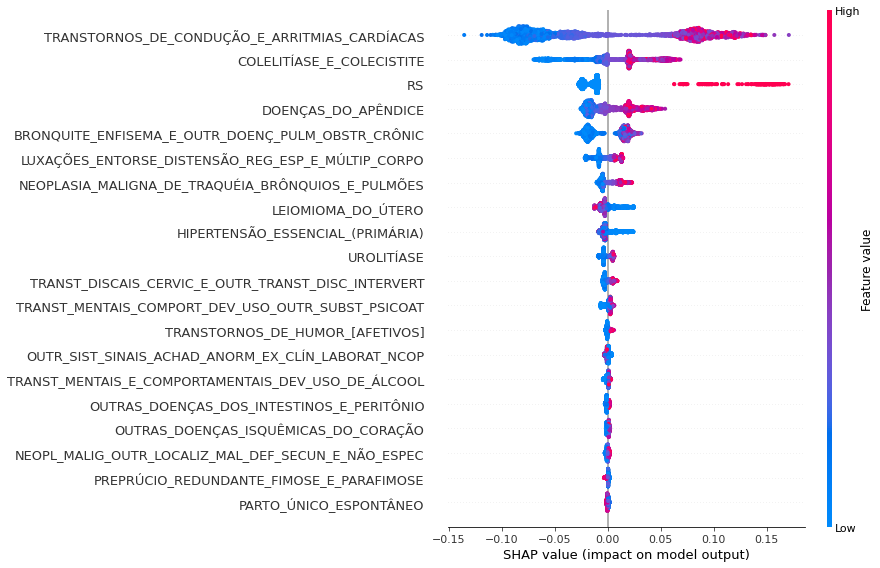

In [23]:
explainer = shap.TreeExplainer(classifier)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values[1], X_test)

In [ ]:
data_for_prediction = X_test.iloc[0]
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)

explainer = shap.TreeExplainer(classifier)

shap_values = explainer.shap_values(data_for_prediction)

shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], data_for_prediction)

## 3. SVM
### 3.1 LinearSVC

In [42]:
start = time.time()
num_feat = 30
kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
scores = pd.DataFrame({"accuracy_train": [], "accuracy_test": [], "scores_train": [], "scores_test": []})
feature_importance_list = []
count = 1
for train_index, test_index in kf.split(X_mm,y):
    print("=============== RUN {} ===============".format(count))
    X_train, X_test = X_mm[train_index], X_mm[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    print("# Fitting the model")
    classifier = LinearSVC()
    classifier.fit(X_train, y_train)
    
    print("# Making predictions")
    y_pred = classifier.predict(X_test) 
    y_pred_train = classifier.predict(X_train)
    
    print("# Calculating metrics")
    print("Train")
    print(metrics.confusion_matrix(y_train, y_pred_train))
    print(metrics.classification_report(y_train, y_pred_train, digits=3))
    print("Test")
    print(metrics.confusion_matrix(y_test, y_pred))
    print(metrics.classification_report(y_test, y_pred, digits=3))
    scores = scores.append({"accuracy_train": metrics.accuracy_score(y_train,y_pred_train),
                  "accuracy_test": metrics.accuracy_score(y_test,y_pred),
                  "scores_train": metrics.precision_recall_fscore_support(y_train,y_pred_train),
                  "scores_test": metrics.precision_recall_fscore_support(y_test,y_pred)}, ignore_index=True)
  
    print("\n")
    count += 1
print("=============== SUMMARY ===============")

print("# Average Metrics")
print("## Train")
avg_accuracy_train = scores["accuracy_train"].mean()
avg_score_train = get_average(scores["scores_train"])
print("accuracy_train:", avg_accuracy_train)
print("precision_train:", avg_score_train[0].mean())
print("recall_train:", avg_score_train[1].mean())
print("f1_score_train:", avg_score_train[2].mean())
print("## Test")
avg_accuracy_test = scores["accuracy_test"].mean()
avg_score_test = get_average(scores["scores_test"])
print("accuracy_test:", avg_accuracy_test)
print("precision_test:", avg_score_test[0].mean())
print("recall_test:", avg_score_test[1].mean())
print("f1_score_test:", avg_score_test[2].mean())

end = time.time()

print("\nTotal run time:", end-start)

=============== RUN 1 ===============
# Fitting the model
# Making predictions
# Calculating metrics
Train
[[2688 1056]
 [1109 2627]]
              precision    recall  f1-score   support

           0      0.708     0.718     0.713      3744
           1      0.713     0.703     0.708      3736

    accuracy                          0.711      7480
   macro avg      0.711     0.711     0.711      7480
weighted avg      0.711     0.711     0.711      7480

Test
[[648 288]
 [312 622]]
              precision    recall  f1-score   support

           0      0.675     0.692     0.684       936
           1      0.684     0.666     0.675       934

    accuracy                          0.679      1870
   macro avg      0.679     0.679     0.679      1870
weighted avg      0.679     0.679     0.679      1870



=============== RUN 2 ===============
# Fitting the model
# Making predictions
# Calculating metrics
Train
[[2690 1054]
 [1123 2613]]
              precision    recall  f1-score   su

### 3.2 SVC (RBF Kernel)

In [27]:
start = time.time()
num_feat = 30
kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
scores = pd.DataFrame({"accuracy_train": [], "accuracy_test": [], "scores_train": [], "scores_test": []})
feature_importance_list = []
count = 1
for train_index, test_index in kf.split(X_mm,y):
    print("=============== RUN {} ===============".format(count))
    X_train, X_test = X_mm[train_index], X_mm[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    print("# Bayesian Optimization")
    def train_model(params):
        C = params[0]

        xf_train_params,xf_val,yf_train_params,yf_val = train_test_split(X_train,y_train,test_size=0.33,random_state=42)

        model = SVC(random_state=42,C=C)

        model.fit(xf_train_params,yf_train_params)
        yf_pred = model.predict(xf_val)

        return metrics.accuracy_score(yf_val, yf_pred)
    space = [
        (0.1,2.0), #n_estimators
    ]
    resultado_gp = gp_minimize(train_model, space, random_state=42, verbose=0, n_calls=10, n_random_starts=10)
    
    C = resultado_gp.x[0]
    
    print("# Fitting the model")
    classifier = SVC(random_state=42,C=C)
    classifier.fit(X_train, y_train)
    
    print("# Making predictions")
    y_pred = classifier.predict(X_test) 
    y_pred_train = classifier.predict(X_train)
    
    print("# Calculating metrics")
    print("Train")
    print(metrics.confusion_matrix(y_train, y_pred_train))
    print(metrics.classification_report(y_train, y_pred_train, digits=3))
    print("Test")
    print(metrics.confusion_matrix(y_test, y_pred))
    print(metrics.classification_report(y_test, y_pred, digits=3))
    scores = scores.append({"accuracy_train": metrics.accuracy_score(y_train,y_pred_train),
                  "accuracy_test": metrics.accuracy_score(y_test,y_pred),
                  "scores_train": metrics.precision_recall_fscore_support(y_train,y_pred_train),
                  "scores_test": metrics.precision_recall_fscore_support(y_test,y_pred)}, ignore_index=True)
  
    print("\n")
    count += 1
print("=============== SUMMARY ===============")

print("# Average Metrics")
print("## Train")
avg_accuracy_train = scores["accuracy_train"].mean()
avg_score_train = get_average(scores["scores_train"])
print("accuracy_train:", avg_accuracy_train)
print("precision_train:", avg_score_train[0].mean())
print("recall_train:", avg_score_train[1].mean())
print("f1_score_train:", avg_score_train[2].mean())
print("## Test")
avg_accuracy_test = scores["accuracy_test"].mean()
avg_score_test = get_average(scores["scores_test"])
print("accuracy_test:", avg_accuracy_test)
print("precision_test:", avg_score_test[0].mean())
print("recall_test:", avg_score_test[1].mean())
print("f1_score_test:", avg_score_test[2].mean())

end = time.time()

print("\nTotal run time:", end-start)

=============== RUN 1 ===============
# Bayesian Optimization
# Fitting the model
# Making predictions
# Calculating metrics
Train
[[2597 1147]
 [ 977 2759]]
              precision    recall  f1-score   support

           0      0.727     0.694     0.710      3744
           1      0.706     0.738     0.722      3736

    accuracy                          0.716      7480
   macro avg      0.716     0.716     0.716      7480
weighted avg      0.717     0.716     0.716      7480

Test
[[634 302]
 [263 671]]
              precision    recall  f1-score   support

           0      0.707     0.677     0.692       936
           1      0.690     0.718     0.704       934

    accuracy                          0.698      1870
   macro avg      0.698     0.698     0.698      1870
weighted avg      0.698     0.698     0.698      1870



=============== RUN 2 ===============
# Bayesian Optimization
# Fitting the model
# Making predictions
# Calculating metrics
Train
[[2559 1185]
 [ 965 2771]]


In [9]:
X_train, X_test, y_train, y_test = train_test_split(pd.DataFrame(X_mm, index=X.index, columns=X.columns),y,random_state=42, test_size=0.3, stratify=y)
num_feat = 30
    
print("# Feature Selection: SFM")
selected_sfm_features = sfm_feature_selector(X_train,y_train,num_feat)
X_train = X_train[selected_sfm_features]
X_test = X_test[selected_sfm_features]
    
print("# Bayesian Optimization")
def train_model(params):
    C = params[0]

    xf_train_params,xf_val,yf_train_params,yf_val = train_test_split(X_train,y_train,test_size=0.33,random_state=42)

    model = SVC(random_state=42,C=C)

    model.fit(xf_train_params,yf_train_params)
    yf_pred = model.predict(xf_val)

    return metrics.accuracy_score(yf_val, yf_pred)
space = [
    (0.1,2.0), #n_estimators
]
resultado_gp = gp_minimize(train_model, space, random_state=42, verbose=0, n_calls=10, n_random_starts=10)

C = resultado_gp.x[0]

print("# Fitting the model")
classifier = SVC(random_state=42,C=C,probability=True)
classifier.fit(X_train, y_train)

print("# Making predictions")
y_pred = classifier.predict(X_test) 
y_pred_train = classifier.predict(X_train)

print("# Calculating metrics")
print("Train")
print(metrics.confusion_matrix(y_train, y_pred_train))
print(metrics.classification_report(y_train, y_pred_train, digits=3))
print("Test")
print(metrics.confusion_matrix(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred, digits=3))

# Feature Selection: SFM
30 selected features (SFM)
# Bayesian Optimization
# Fitting the model
# Making predictions
# Calculating metrics
Train
[[2245 1031]
 [1082 2187]]
              precision    recall  f1-score   support

           0      0.675     0.685     0.680      3276
           1      0.680     0.669     0.674      3269

    accuracy                          0.677      6545
   macro avg      0.677     0.677     0.677      6545
weighted avg      0.677     0.677     0.677      6545

Test
[[939 465]
 [509 892]]
              precision    recall  f1-score   support

           0      0.648     0.669     0.658      1404
           1      0.657     0.637     0.647      1401

    accuracy                          0.653      2805
   macro avg      0.653     0.653     0.653      2805
weighted avg      0.653     0.653     0.653      2805



l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!


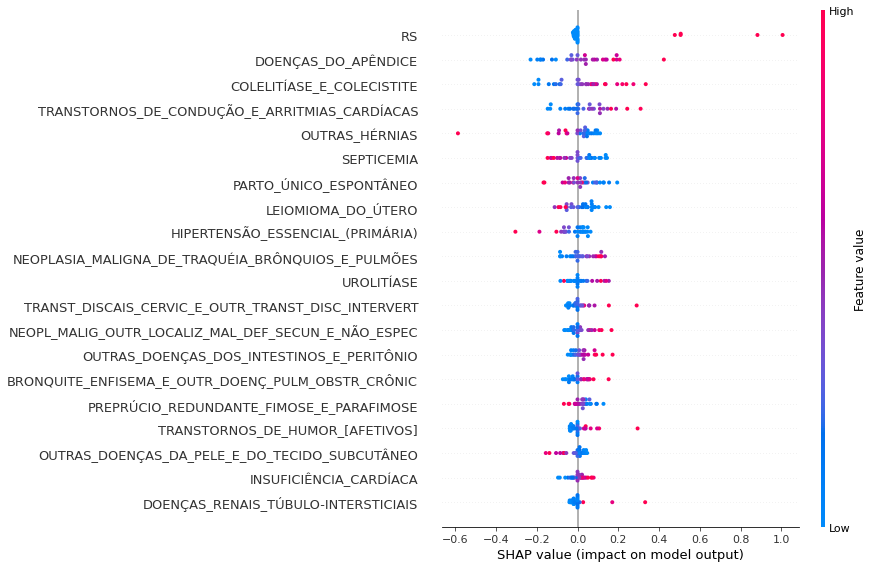

In [10]:
explainer = shap.KernelExplainer(classifier.predict_proba, shap.sample(X_train, 50), link="logit")
shap_values = explainer.shap_values(X_test[0:30])
shap.summary_plot(shap_values[1], X_test[0:30])

In [16]:
shap.initjs()
data_for_prediction = X_test.iloc[0]
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)
shap_values = explainer.shap_values(data_for_prediction)
shap.force_plot(explainer.expected_value[1], shap_values[1], data_for_prediction)

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
